# This plots mean pre-Ictal PLV with the SOZ chan at all other channels across all seizures for a patient

It is used for determining which contrast channels to use for PLV-based seizure prediction

In [1]:
import numpy as np
import pandas as pd
import scipy.io
import os
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import preprocessing
import sys
from scipy import stats
import scipy.io as sio
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Reimport functions
import imp
imp.reload(ief)

In [2]:
# Define frequency bands
freq_bands=[(1, 125), (0, 4), (4, 8), (8, 13), (13,30), (30,50), (70, 100)]
band_labels=['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma']
n_band=len(freq_bands)
print('# of freq bands %d' % n_band)

# of freq bands 7


In [ ]:
# Just one seizure sbox

# Load Data
ieeg, Sf, tpts_sec=ief.import_ieeg('NA_d1_sz2.mat')
n_chan, n_tpt = ieeg.shape
print('chans %d' % n_chan)
print('tpts %d' % n_tpt)

# Downsample data to 250 Hz
if Sf == 500:
    print('Downsampling data to 250 Hz')
    ieeg = signal.decimate(ieeg, 2, axis=1, zero_phase=True)
    tpts_sec=signal.decimate(tpts_sec, 2, axis=0, zero_phase=True)
    Sf = 250
elif Sf != 250:
    raise ValueError('Sf needs to be 500 or 250')

# Define chans of interest
soz_id=12 #RHD1-2
ctrl_id=[0,10] #LHD1-2, 

# Normally I would need to bandpass filter the data first

# Moving window Hilbert
hilby_soz=signal.hilbert(ieeg[soz_id,:Sf])
hilby_soz_nrm=hilby_soz.copy()
hilby_ctrl=signal.hilbert(ieeg[ctrl_id,:Sf])
hilby_diff=hilby_soz-hilby_ctrl
hilby_diff_nrm=np.divide(hilby_diff,np.abs(hilby_diff))
print(hilby_diff_nrm.shape)
# avg hilbert results in that window

In [25]:
# Average across all seizures
# sub='NA'
# seed_chan='RHD1-2'
# sub='CC'
# seed_chan='LHD1-2'
# seed_chan='LMT2-3'
# sub='CJ'
# seed_chan='LHD2-3'
# sub='CO'
# seed_chan='RHD1-2'
# seed_chan='LHD1-2'
# seed_chan='RMT2-3'
# sub='CT'
# seed_chan='LHD1-2'
# sub='IB'
#seed_chan='LAT1-2'
# seed_chan='LAT2-3'
#seed_chan='LMT3-4'
# seed_chan='LPIT3-4'
# sub='JW'
# seed_chan='LAT2-3'
# seed_chan='LAT1-2'
# sub='RB'
# seed_chan='LHD1-2'
sub='TF'
seed_chan='RHD1-2'
use_asin=False
#use_asin=True
path_dict=ief.get_path_dict()
print('Sub is %s' % sub)
print('Seed is %s' % seed_chan )
print('use_asin set to {}'.format(use_asin))

# IMPORT CHAN NAMES
chan_labels=ief.import_chan_labels(sub)
seed_chan_id=chan_labels.index(seed_chan)
n_chan=len(chan_labels)
print('Seed chan is %s' % seed_chan)
ieeg_root = path_dict['ieeg_root']

# Get list of seizures
onset_csv_dir=path_dict['onset_csv']
onset_csv_fname=os.path.join(onset_csv_dir,sub+'_clinician_onset_offset.csv')
print('Importing file %s' % onset_csv_fname)
onset_df=pd.read_csv(onset_csv_fname)

use_ser=onset_df['USE4CLASSIFIER']
use_szrs=list()
# onset_chans=list()
for row_id, quality in enumerate(use_ser):
    if quality=='use':
        szr_name=sub+'_d'+str(onset_df.iloc[row_id,0])+'_sz'+str(onset_df.iloc[row_id,1])
        use_szrs.append(szr_name)
n_use_szrs=len(use_szrs)
print('%d usable szrs:' % n_use_szrs)
print(use_szrs)

# Define frequency bands
bands=list()
bands.append((0,4)) # Delta
bands.append((4,8)) # Theta
bands.append((8,13)) # Alpha
bands.append((13,30)) # Beta
bands.append((30,50)) # Gamma
bands.append((70,100)) # High Gamma
n_band=len(bands)

# Loop over usable files
plv_all_szrs=np.zeros((n_band,n_chan,n_use_szrs))
#for szr_ct, szr_name in enumerate(use_szrs[:1]):
for szr_ct, szr_name in enumerate(use_szrs): #TODO use all szrs!!!
    # Load data
    in_fname=os.path.join(ieeg_root,sub,'EEG_MAT',szr_name+'.mat')
    if not os.path.isfile(in_fname):
        # Must be a subclinical seizure
        in_fname=os.path.join(ieeg_root,sub,'EEG_MAT',szr_name+'_sc.mat')
    szr_name_full=in_fname.split('/')[-1]
    ieeg, Sf, tpts_sec=ief.import_ieeg(szr_name_full)
    # Note, this function automatically detrends data just in case.
    # Some patients have a crazy trend in the first channel

    # Downsample data to 250 Hz if need be
    orig_tpts_sec=tpts_sec.copy()
    if Sf == 500:
        print('Downsampling data to 250 Hz')
        ieeg = signal.decimate(ieeg, 2, axis=1, zero_phase=True)
        tpts_sec=signal.decimate(tpts_sec, 2, axis=0, zero_phase=True)
        Sf = 250
    elif Sf != 250:
        raise ValueError('Sf needs to be 500 or 250')
    wind_len=250
    wind_step=int(np.round(wind_len/10))
    filt_order=4
        
    # Get time point and channel of szr onset
    onset_orig_tpt, onset_chan=ief.clin_onset_tpt_and_chan(szr_name, onset_df)
    onset_chan_id = chan_labels.index(onset_chan)
    # Need to recompute time point of clinician onset due to possible change in sampling rate
    onset_sec=orig_tpts_sec[onset_orig_tpt]
    onset_tpt=dg.find_nearest(tpts_sec,onset_sec)
    
    # Loop over channels
    n_chan=len(chan_labels)
    for chan_ct in range(n_chan):
        if seed_chan_id!=chan_ct:
            use_elec=[seed_chan_id, chan_ct]
            # TODO use only preictal tpts
            hilb_phz_dif, hilb_sec = ief.bp_hilb_phz_dif(ieeg[use_elec, :onset_tpt], Sf,
                                                wind_len, wind_step, tpts_sec, bands,
                                                filt_order)
            if use_asin:
                hilb_plv=dg.asin_trans(np.abs(hilb_phz_dif))
            else:
                hilb_plv=np.abs(hilb_phz_dif)
            plv_all_szrs[:,chan_ct,szr_ct]=np.mean(hilb_plv,axis=1)/np.std(hilb_plv,axis=1) #average across all tpts
            #plv_all_szrs[:,chan_ct,szr_ct]=np.mean(hilb_plv,axis=1)
            
# Avg pre-ictal PLV between seed and other channels
plv_szr_mn=np.mean(plv_all_szrs,axis=2)
#plv_szr_mn=np.mean(plv_all_szrs,axis=2)/np.std(plv_all_szrs,axis=2)
print('done!')

Sub is TF
Seed is RHD1-2
use_asin set to False
Loading /Users/davidgroppe/ONGOING/TWH_EEG/TF/TF_channel_info.csv
Seed chan is RHD1-2
Importing file /Users/davidgroppe/Dropbox/TWH_INFO/CLINICIAN_ONSET_TIMES/TF_clinician_onset_offset.csv
12 usable szrs:
['TF_d4_sz2', 'TF_d4_sz3', 'TF_d5_sz1', 'TF_d5_sz2', 'TF_d5_sz3', 'TF_d5_sz4', 'TF_d6_sz1', 'TF_d6_sz2', 'TF_d6_sz3', 'TF_d7_sz1', 'TF_d7_sz2', 'TF_d8_sz1']
Loading /Users/davidgroppe/ONGOING/TWH_EEG/TF/EEG_MAT/TF_d4_sz2.mat
Downsampling data to 250 Hz
Getting clinical onset time for TF: Day 4, Szr 2
Loading /Users/davidgroppe/ONGOING/TWH_EEG/TF/EEG_MAT/TF_d4_sz3.mat
Downsampling data to 250 Hz
Getting clinical onset time for TF: Day 4, Szr 3
Loading /Users/davidgroppe/ONGOING/TWH_EEG/TF/EEG_MAT/TF_d5_sz1.mat
Downsampling data to 250 Hz
Getting clinical onset time for TF: Day 5, Szr 1
Loading /Users/davidgroppe/ONGOING/TWH_EEG/TF/EEG_MAT/TF_d5_sz2.mat
Downsampling data to 250 Hz
Getting clinical onset time for TF: Day 5, Szr 2
Loading /Us

Sub is TF
Seed is RHD1-2
All szrs: Highest PLV is with chan #21 LPT1-2
done


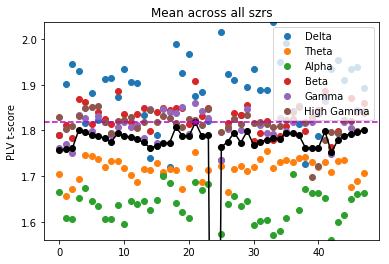

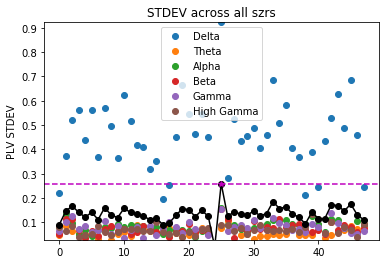

In [26]:
print('Sub is %s' % sub)
print('Seed is %s' % seed_chan )

show_chans=np.setdiff1d(np.arange(n_chan),seed_chan_id)

# Plot the last seizure loaded
# plv_this_szr=np.squeeze(plv_all_szrs[:,:,szr_ct])
# mn_plv=np.mean(plv_this_szr,axis=0)

# mx=np.max(plv_this_szr[:,show_chans])
# mn=np.min(plv_this_szr[:,show_chans])
# mx_id=np.argmax(mn_plv)

# plt.figure(1)
# # plt.plot(plv_this_szr[:,show_chans].T,'o')
# # plt.plot(mn_plv[show_chans],'ko-')
# plt.plot(plv_this_szr.T,'o')
# plt.plot(mn_plv,'ko-')
# plt.plot(mx_id,mn_plv[mx_id],'m*')
# xlim=plt.xlim()
# plt.plot(xlim,[mn_plv[mx_id], mn_plv[mx_id]],'m--')
# plt.ylabel('PLV t-score')
# plt.ylim([mn, mx])
# plt.xlim(xlim)

# print('Last szr: Highest PLV is with chan #%d %s' % (mx_id,chan_labels[mx_id]))

# PLOT THE AVG ACROSS ALL SZRS
plv_szr_mn=np.nan_to_num(plv_szr_mn)
mn_plv=np.mean(plv_szr_mn,axis=0)
#np.nan_to_num(mn_plv)
mx=np.max(plv_szr_mn[:,show_chans])
mn=np.min(plv_szr_mn[:,show_chans])
mx_id=np.argmax(mn_plv)

plt.figure(2)
#plt.plot(plv_szr_mn.T,'o')
for band_ct in range(n_band):
    plt.plot(plv_szr_mn[band_ct,:],'o',label=band_labels[band_ct])
plt.plot(mn_plv,'ko-')
plt.plot(mx_id,mn_plv[mx_id],'m*')
xlim=plt.xlim()
plt.plot(xlim,[mn_plv[mx_id], mn_plv[mx_id]],'m--')
plt.ylabel('PLV t-score')
plt.ylim([mn, mx])
plt.xlim(xlim)
plt.title('Mean across all szrs')
plt.legend(loc='best')

print('All szrs: Highest PLV is with chan #%d %s' % (mx_id,chan_labels[mx_id]))

# PLOT THE STDEV ACROSS ALL SZRS
plv_szr_sd=np.nan_to_num(np.std(plv_all_szrs,axis=2))
mn_sd_plv=np.mean(plv_szr_sd,axis=0)
#np.nan_to_num(mn_plv)
mx=np.max(plv_szr_sd[:,show_chans])
mn=np.min(plv_szr_sd[:,show_chans])
mx_id=np.argmax(mn_sd_plv)

plt.figure(3)
for band_ct in range(n_band):
    plt.plot(plv_szr_sd[band_ct,:],'o',label=band_labels[band_ct])
plt.plot(mn_sd_plv,'ko-')
plt.plot(mx_id,mn_sd_plv[mx_id],'m*')
xlim=plt.xlim()
plt.plot(xlim,[mn_sd_plv[mx_id], mn_sd_plv[mx_id]],'m--')
plt.ylabel('PLV STDEV')
plt.ylim([mn, mx])
# plt.ylim([mn, .01])
plt.xlim(xlim)
plt.title('STDEV across all szrs')
plt.legend(loc='best')

print('done')

(6, 871)
(6, 871)


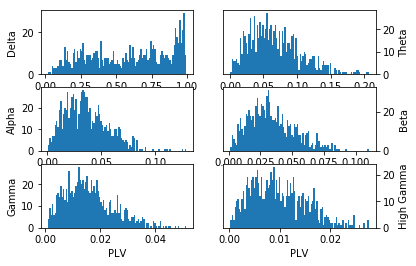

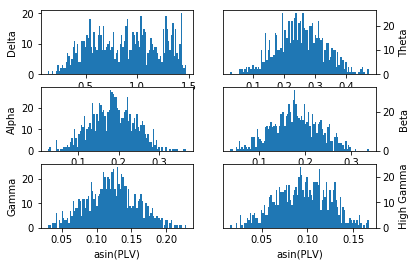

In [51]:
# Look at effect of asin transformation on one seizure
temp_raw=np.abs(hilb_phz_dif)
temp_asin=dg.asin_trans(temp_raw)
print(temp_raw.shape)
print(temp_asin.shape)

plt.figure(1)
plt.clf
for a in range(6):
    ax=plt.subplot(3,2,a+1)
    ax.hist(temp_raw[a,:],bins=100)
    plt.ylabel(band_labels[a])
    if a in [1,3,5]:
        ax.yaxis.set_ticks_position('right')
        ax.yaxis.set_label_position('right')
    if a in [5,4]:
        plt.xlabel('PLV')
plt.savefig('asin_xmple_plv1.png')
        
plt.figure(2)
plt.clf
for a in range(6):
    ax=plt.subplot(3,2,a+1)
    plt.hist(temp_asin[a,:],bins=100)
    plt.ylabel(band_labels[a])
    if a in [1,3,5]:
        ax.yaxis.set_ticks_position('right')
        ax.yaxis.set_label_position('right')
    if a in [5,4]:
        plt.xlabel('asin(PLV)')
plt.savefig('asin_xmple_plv2.png')

done


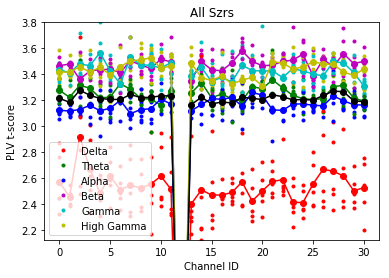

In [47]:
show_chans=np.setdiff1d(np.arange(n_chan),seed_chan_id)

mx=np.max(plv_all_szrs[:,show_chans,:])
mn=np.min(plv_all_szrs[:,show_chans,:])

freq_colors=['r','g','b','m','c','y']
plt.figure(4)
for szr_ct in range(n_use_szrs):
    for band_ct in range(n_band):
        plt.plot(np.squeeze(plv_all_szrs[band_ct,:,szr_ct]),'.',color=freq_colors[band_ct],
                label=band_labels[band_ct])
    if szr_ct==0:
        plt.legend()
        

# Plot mean of each freq band
for band_ct in range(n_band):
    plt.plot(np.squeeze(plv_szr_mn[band_ct,:]),'-o',color=freq_colors[band_ct])

# Plot mean across all freq bands
plv_grand_mn=np.mean(np.nan_to_num(plv_szr_mn),axis=0)
plt.plot(plv_grand_mn,'k-o')

# plt.plot(mn_plv,'ko-')
# plt.plot(mx_id,mn_plv[mx_id],'m*')
xlim=plt.xlim()
# plt.plot(xlim,[mn_plv[mx_id], mn_plv[mx_id]],'m--')
plt.ylabel('PLV t-score')
plt.title('All Szrs')
plt.ylim([mn, mx])
plt.xlim(xlim)
plt.xlabel('Channel ID')

print('done')

In [ ]:
#TO DOD arc sin transofrm

In [ ]:
for szr_ct, szr_name in enumerate(use_szrs):
    # Plot all seizures individually and output to disk
    plv_this_szr=np.squeeze(plv_all_szrs[:,:,szr_ct])
    mn_plv=np.mean(plv_this_szr,axis=0)

    mx=np.max(plv_this_szr[:,show_chans])
    mn=np.min(plv_this_szr[:,show_chans])
    mx_id=np.argmax(mn_plv)

    plt.figure(1)
    plt.clf()
    # plt.plot(plv_this_szr[:,show_chans].T,'o')
    # plt.plot(mn_plv[show_chans],'ko-')
    plt.plot(plv_this_szr.T,'o')
    plt.plot(mn_plv,'ko-')
    plt.plot(mx_id,mn_plv[mx_id],'m*')
    xlim=plt.xlim()
    plt.plot(xlim,[mn_plv[mx_id], mn_plv[mx_id]],'m--')
    plt.ylabel('PLV t-score')
    plt.ylim([mn, mx])
    plt.xlim(xlim)
    plt.title(szr_name)
    out_figname=szr_name+'_plv.png'
    print('Saving to file %s' % out_figname)
    plt.savefig(out_figname)

    print('%s: Highest PLV is with chan #%d %s' % (szr_name,mx_id,chan_labels[mx_id]))

In [ ]:
wind_len=Sf
wind_step=int(np.round(Sf/10))
filt_order=4
# hilb_phz_dif, hilb_sec=ief.bp_hilb_phz_dif(ieeg[[soz_id, ctrl_id],:], Sf, 
#                     wind_len, wind_step, tpts_sec, freq_bands, filt_order)
ctrl_ids=[0, 10] #LHD1-2;LPT2-3
use_elecs=list()
use_elecs.append(soz_id)
use_elecs=use_elecs+ctrl_ids
print(use_elecs)
hilb_phz_dif, hilb_sec=ief.bp_hilb_phz_dif(ieeg[use_elecs,:], Sf, 
                    wind_len, wind_step, tpts_sec, freq_bands, filt_order)
# hilb_phz_dif, hilb_sec=ief.bp_hilb_phz_dif(ieeg[[soz_id, ctrl_ids],:], Sf, 
#                     wind_len, wind_step, tpts_sec, freq_bands, filt_order)

print(hilb_phz_dif.shape)

In [ ]:
print(hilb_phz_dif.shape)

In [ ]:
hilb_plv1=np.copy(hilb_phz_dif)
#hilb_plv1=np.abs(np.squeeze(hilb_phz_dif))
print(hilb_plv1.shape)
alph=1/(2**4)
for a in range(1,len(hilb_sec)):
     hilb_plv1[:,a]=hilb_plv1[:,a]*alph+hilb_plv1[:,a-1]*(1-alph)
hilb_plv1=np.abs(hilb_plv1)
print(hilb_plv1.shape)

In [ ]:
plt.figure(1)
plt.clf()
plt.plot(hilb_sec,np.squeeze(np.abs(hilb_phz_dif)).T)

plt.figure(2)
plt.clf()
plt.plot(hilb_sec,np.squeeze(hilb_plv1.T))

print(hilb_phz_dif.shape)

In [ ]:
# LOAD FEATURES FROM DISK
plv_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/PLV_LAG0/NA/NA_d1_sz2_plv_lag0.npz'
#plv_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/PLV_LAG4/NA/NA_d1_sz2_plv_lag4.npz'
plv_dict=np.load(plv_fname)
print(plv_dict.keys())
plv_dict['ftrs'].shape

In [ ]:
#nbook_ftrs=hilb_plv1
nbook_ftrs=np.mean(np.abs(hilb_phz_dif),1)
plt.figure(1)
plt.clf()
plt.plot(hilb_sec,np.squeeze(nbook_ftrs).T)

plt.figure(2)
plt.clf()
for a in range(plv_dict['ftrs'].shape[0]):
    plt.plot(plv_dict['time_wind_sec'],np.squeeze(plv_dict['ftrs'][a,:]).T,
             label=plv_dict['ftr_list'][a])
plt.legend(loc='upper left')

plt.figure(3)
plt.clf()
plt.plot(plv_dict['time_wind_sec'],np.squeeze(nbook_ftrs.T)-np.squeeze(plv_dict['ftrs']).T)

print('done')

In [ ]:
# print(hilby_soz[0])
# print(hilby_ctrl[0])
print(hilby_diff[0])
print(np.abs(hilby_diff[0]))
print(hilby_diff[0]/np.abs(hilby_diff[0]))
print(hilby_diff_nrm[0])
np.sqrt((0.879324682034**2)+(0.476222745747**2))

In [ ]:
chan_labels=ief.import_chan_labels(sub)
for ct, chan in enumerate(chan_labels):
    print('%d %s' % (ct, chan))


In [ ]:
# Load an example data set
#in_fname='/home/dgroppe/TWH_EEG/NA/EEG_MAT/NA_d1_sz2.mat'
in_fname='/Users/davidgroppe/ONGOING/TWH_EEG_ORIG/NA/NA_d1_sz2.mat'
mat_dat=sio.loadmat(in_fname)
Sf=mat_dat['Sf']
#mat_dat.keys()

# Detrend data. Some patients have a crazy trend in the first channel
vltg_dat=signal.detrend(mat_dat['matrix_bi'],0)
# dat=signal.detrend(vltg_dat,0)
# plt.figure(1)
# plt.clf()
# plt.plot(mat_dat['matrix_bi'][:,0],'b-')
# plt.plot(dat[:,0],'r--')

if Sf==500:
    # Downsample to 250 Hz
    print('Downsampling data to 250 Hz')
    vltg_dat=signal.decimate(vltg_dat,2,axis=0,zero_phase=True)
    Sf=250
elif Sf==250:
    pass
    #vltg_dat=mat_dat['matrix_bi']
else:
    raise ValueError('Sf needs to be 500 or 250')
    
# Get SOZ chan
# soz_id=0 # TODO ?? get actual chan
# n_tpt, n_chan=mat_dat['matrix_bi'].shape
n_tpt, n_chan=vltg_dat.shape
data_time_sec=np.arange(0,n_tpt)/Sf


bp_data=np.zeros((n_band,n_chan,n_tpt))
filt_order=4
# Bandpass filter the data
for band_ct, band in enumerate(freq_bands):
    print('Working on {} Hz'.format(band))
    bp_data[band_ct,:,:]=ief.causal_butter(dat.T,Sf,band,filt_order)
    
# plt.figure(2)
# plt.clf()
# plt.plot(dat[:,0],'r-')
# plt.plot(bp_data[0,0,:],'g--')
# plt.plot(bp_data[3,0,:],'m--')

In [ ]:
wind_len=Sf
wind_step=int(np.round(Sf/10))
filt_order=4
hilb_mag, hilb_inst_freq, hilb_sec=ief.bp_hilb_mag(vltg_dat[:,soz_id:soz_id+1].T, 
                                                               Sf, wind_len, wind_step,
                                                               data_time_sec, freq_bands, 
                                                               filt_order)
dg.trimmed_normalize(hilb_mag,0.4);

In [ ]:
# Instantaneous freq sandbox
n_band=hilb_inst_freq.shape[0]
plt.figure(31)
plt.clf()
for a in range(n_band):
    plt.plot(hilb_sec,hilb_inst_freq[a,:],label=band_labels[a])
# The chip is from about 116 to 123 seconds
ylim=plt.ylim()
plt.plot([116, 116],ylim,'k--')
plt.ylim(ylim)
plt.xlabel('Sec')
plt.ylabel('Hz')
plt.xlim([hilb_sec[0], hilb_sec[-1]])
plt.title('Inst. Freq')
plt.legend()

# Plot change in instantaneous freq
plt.figure(32)
plt.clf()
for a in range(n_band):
    plt.subplot(3,2,a+1)
    plt.plot(hilb_sec[:-1],np.diff(hilb_inst_freq[a,:]))
    # The chip is from about 116 to 123 seconds
    ylim=plt.ylim()
    plt.plot([116, 116],ylim,'k--')
    plt.ylim(ylim)
    plt.xlabel('Sec')
    plt.ylabel('Hz')
    plt.xlim([hilb_sec[0], hilb_sec[-1]])
    plt.title('Delta Inst. Freq '+band_labels[a])

    
# Plot change in instantaneous freq (zoom in on onset)
onset_id=dg.find_nearest(hilb_sec,113)
plt.figure(33)
plt.clf()
tempdif=np.diff(hilb_inst_freq);
for a in range(n_band):
    plt.subplot(3,2,a+1)
    plt.plot(hilb_sec[onset_id-Sf:onset_id+Sf],
             tempdif[a,onset_id-Sf:onset_id+Sf])
    # The chip is from about 116 to 123 seconds
    ylim=plt.ylim()
    plt.plot([116, 116],ylim,'k--')
    plt.ylim(ylim)
    plt.xlabel('Sec')
    plt.ylabel('Hz')
    plt.xlim([hilb_sec[onset_id-Sf], hilb_sec[onset_id+Sf]])
    plt.title('Delta Inst. Freq '+band_labels[a])    
    
print('Done!')

In [ ]:
temp_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/IFREQ_LAG0/NA/NA_d1_sz2_ifreq_lag0.npz'
temp_dict=np.load(temp_fname)
print(temp_dict.keys())

n_band=temp_dict['ftrs'].shape[0]
plt.figure(41)
plt.clf()
for a in range(n_band):
    plt.plot(temp_dict['time_wind_sec'],temp_dict['ftrs'][a,:],label=temp_dict['ftr_list'][a])
# The chip is from about 116 to 123 seconds
ylim=plt.ylim()
plt.plot([116, 116],ylim,'k--')
plt.ylim(ylim)
plt.xlabel('Sec')
plt.ylabel('Z')
plt.xlim([hilb_sec[0], hilb_sec[-1]])
plt.title('Inst. Freq')
plt.legend()

print('Done.')

In [ ]:
print(hilb_inst_freq.shape)
print(temp_dict['ftrs'].shape)
print(np.max(np.abs(hilb_inst_freq-temp_dict['ftrs'][1:,:])))
print(np.max(np.abs(hilb_inst_freq[1:,:]-temp_dict['ftrs'][2:,:])))

plt.figure(50)
plt.clf()
for a in range(6):
    plt.subplot(3,2,a+1)
    plt.plot(hilb_inst_freq[a,:],'b-')
    plt.plot(temp_dict['ftrs'][a+1,:],'r--')
    plt.title(band_labels[a])
    
plt.figure(51)
plt.clf()
plt.plot(hilb_inst_freq[0,:],'b-')
plt.plot(temp_dict['ftrs'][1,:],'r--')

plt.figure(52)
plt.clf()
plt.plot(hilb_inst_freq[0,:],'b-')

print('Done')

In [ ]:
# Delt Instantaneous freq (within the moving window) sandbox
plt.figure(31)
plt.clf()
plt.plot(hilb_sec,hilb_delt_freq.T)
# The chip is from about 116 to 123 seconds
ylim=plt.ylim()
plt.plot([116, 116],ylim,'k--')
plt.ylim(ylim)
plt.xlabel('Sec')
plt.ylabel('Hz')
plt.xlim([hilb_sec[0], hilb_sec[-1]])
plt.title('Delta Inst. Freq (within moving window)')

# Plot mean change in instantaneous freq
plt.figure(32)
plt.clf()
for a in range(n_band):
    plt.subplot(3,2,a+1)
    plt.plot(hilb_sec,hilb_delt_freq[a,:])
    # The chip is from about 116 to 123 seconds
    ylim=plt.ylim()
    plt.plot([116, 116],ylim,'k--')
    plt.ylim(ylim)
    plt.xlabel('Sec')
    #plt.ylabel('Hz')
    plt.ylabel('Z')
    plt.xlim([hilb_sec[0], hilb_sec[-1]])
    plt.title('Mean Delta Inst. Freq '+band_labels[a])

    
# Plot change in instantaneous freq (zoom in on onset)
onset_id=dg.find_nearest(hilb_sec,113)
plt.figure(33)
plt.clf()
for a in range(n_band):
    plt.subplot(3,2,a+1)
    plt.plot(hilb_sec[onset_id-Sf:onset_id+Sf],
             hilb_delt_freq[a,onset_id-Sf:onset_id+Sf])
    # The chip is from about 116 to 123 seconds
    ylim=plt.ylim()
    plt.plot([116, 116],ylim,'k--')
    plt.ylim(ylim)
    plt.xlabel('Sec')
    #plt.ylabel('Hz')
    plt.ylabel('Z')
    plt.xlim([hilb_sec[onset_id-Sf], hilb_sec[onset_id+Sf]])
    plt.title('Delta Inst. Freq '+band_labels[a])    
    
print('Done!')

In [ ]:
# SMOOOTHED Instantaneous freq sandbox
smooth_inst_freq=np.copy(hilb_inst_freq)
n_wind=hilb_inst_freq.shape[1]
pptn=1/(2**6) #smaller values=more smoothing
for a in range(0,n_wind-1):
    smooth_inst_freq[:,a+1]=(1-pptn)*smooth_inst_freq[:,a]+pptn*smooth_inst_freq[:,a+1]

plt.figure(31)
plt.clf()
plt.plot(hilb_sec,smooth_inst_freq.T)
# The chip is from about 116 to 123 seconds
ylim=plt.ylim()
plt.plot([116, 116],ylim,'k--')
plt.ylim(ylim)
plt.xlabel('Sec')
plt.ylabel('Hz')
plt.xlim([hilb_sec[0], hilb_sec[-1]])
plt.title('Inst. Freq')

# Plot change in instantaneous freq
plt.figure(32)
plt.clf()
for a in range(n_band):
    plt.subplot(3,2,a+1)
    plt.plot(hilb_sec[:-1],np.diff(smooth_inst_freq[a,:]))
    # The chip is from about 116 to 123 seconds
    ylim=plt.ylim()
    plt.plot([116, 116],ylim,'k--')
    plt.ylim(ylim)
    plt.xlabel('Sec')
    plt.ylabel('Hz')
    plt.xlim([hilb_sec[0], hilb_sec[-1]])
    plt.title('Delta Inst. Freq '+band_labels[a])

    
# Plot change in instantaneous freq (zoom in on onset)
onset_id=dg.find_nearest(hilb_sec,113)
plt.figure(33)
plt.clf()
tempdif=np.diff(smooth_inst_freq);
for a in range(n_band):
    plt.subplot(3,2,a+1)
    plt.plot(hilb_sec[onset_id-Sf:onset_id+Sf],
             tempdif[a,onset_id-Sf:onset_id+Sf])
    # The chip is from about 116 to 123 seconds
    ylim=plt.ylim()
    plt.plot([116, 116],ylim,'k--')
    plt.ylim(ylim)
    plt.xlabel('Sec')
    plt.ylabel('Hz')
    plt.xlim([hilb_sec[onset_id-Sf], hilb_sec[onset_id+Sf]])
    plt.title('Delta Inst. Freq '+band_labels[a])    
    
print('Done!')

In [ ]:
# Apply NON-causal hilbert transform
soz_id=12
hilby_data=signal.hilbert(bp_data[:,soz_id,:])
print('done!')

In [ ]:
difreq.keys()

In [ ]:
difreq_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/DIFREQ_LAG8/NA/NA_d1_sz2_difreq_lag8.npz'
difreq=np.load(difreq_fname)
print(difreq.keys())

plt.figure(31)
plt.clf()
plt.plot(difreq['time_wind_sec'],difreq['ftrs'].T)
# The chip is from about 116 to 123 seconds
ylim=plt.ylim()
plt.plot([116, 116],ylim,'k--')
plt.ylim(ylim)
plt.xlabel('Sec')
plt.ylabel('Hz')
plt.xlim([difreq['time_wind_sec'][0], difreq['time_wind_sec'][-1]])
plt.title('Diff of Inst. Freq');

plt.figure(32)
plt.clf()
for a in range(difreq['ftrs'].shape[0]):
    plt.plot(difreq['time_wind_sec'],difreq['ftrs'][a,:],label=difreq['ftr_list'][a])
# The chip is from about 116 to 123 seconds
ylim=plt.ylim()
plt.plot([116, 116],ylim,'k--')
plt.ylim(ylim)
plt.xlabel('Sec')
plt.ylabel('Hz')
plt.xlim([111, 121])
plt.legend()
plt.title('Diff of Inst. Freq');

In [ ]:
hilby_mag=np.abs(hilby_data)
hilby_phz=np.unwrap(np.angle(hilby_data))
instant_freq = (np.diff(hilby_phz)/(2.0*np.pi) * Sf)
hilby_mag.shape

In [ ]:
# Plot raw data and magnitude
plt.figure(1)
plt.clf()
plt.subplot(2,1,1)
plt.plot(data_time_sec,vltg_dat[:,soz_id])

plt.subplot(2,1,2)
plt.plot(data_time_sec,hilby_mag.T);
plt.xlabel('Sec')

start_tpt=28800
stop_tpt=start_tpt+Sf*5
plt.figure(2)
plt.clf()
plt.subplot(2,1,1)
plt.plot(data_time_sec[start_tpt:stop_tpt],vltg_dat[start_tpt:stop_tpt,soz_id])

plt.subplot(2,1,2)
plt.plot(data_time_sec[start_tpt:stop_tpt],hilby_mag[:,start_tpt:stop_tpt].T);
plt.xlabel('Sec')

In [ ]:
# freq_bands=[(0, 4), (4, 8), (8, 13), (13,30), (30,50), (70, 100)]
# band_labels=['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma']
# n_band=len(freq_bands)

freq_id=3 # 3=beta

# Plot raw data and phase
start_tpt=28500
stop_tpt=start_tpt+Sf*5
plt.figure(2)
plt.clf()
plt.subplot(4,1,1)
#plt.plot(vltg_dat[start_tpt:stop_tpt,soz_id])
#plt.plot(bp_data[freq_id,soz_id,start_tpt:stop_tpt],'r-')
show_dat=np.copy(bp_data[:,soz_id,start_tpt:stop_tpt])
show_raw_dat=np.copy(vltg_dat[start_tpt:stop_tpt,:]).T
dg.normalize(show_dat)
#dg.trimmed_normalize(show_raw_dat,0.4)
dg.normalize(show_raw_dat)
plt.plot(show_dat[freq_id,:],'r-',label='Bpass')
#plt.plot(show_raw_dat[:,soz_id],'b-')
plt.plot(show_raw_dat[soz_id,:],'b-',label='iEEG')
plt.xticks([])
plt.legend()
plt.ylabel('Voltage')
plt.title('Onset: '+band_labels[freq_id])

plt.subplot(4,1,2)
plt.plot(hilby_phz[freq_id,start_tpt:stop_tpt].T);
plt.ylabel('Instant Phase')
plt.xticks([])

plt.subplot(4,1,3)
plt.plot(data_time_sec[start_tpt:stop_tpt],instant_freq[freq_id,start_tpt:stop_tpt].T);
plt.ylabel('Instant Freq')
ylim=plt.ylim()
# The chip is from about 116 to 123 seconds
plt.plot([116, 116],ylim,'k--')
#plt.plot([123, 123],ylim,'k--')

plt.subplot(4,1,4)
plt.plot(data_time_sec[start_tpt:stop_tpt-1],np.diff(instant_freq[freq_id,start_tpt:stop_tpt]));
plt.ylabel('Delta Inst. Freq')
plt.ylim([-10, 10])
ylim=plt.ylim()
# The chip is from about 116 to 123 seconds
plt.plot([116, 116],ylim,'k--')
# plt.plot([123, 123],ylim,'k--')
plt.xlabel('Sec')

print('done!')

In [ ]:
# HILBERT ON ENTIRE DATA 

# Plot raw data and phase
# freq_bands=[(0, 4), (4, 8), (8, 13), (13,30), (30,50), (70, 100)]
# band_labels=['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma']
# n_band=len(freq_bands)

freq_id=3 # 3=beta
a=0
ylim=[-20, 40]

# onset
start_tpt=28800
stop_tpt=start_tpt+Sf*5
dat_clip=np.copy(vltg_dat[start_tpt:stop_tpt,:]).T
bp_clip=np.copy(np.squeeze(bp_data[:,soz_id,start_tpt:stop_tpt]))
                
plt.figure(2)
plt.clf()
plt.subplot(3,2,1+a)
dat_clipZ=dat_clip[soz_id,:]
dat_clipZ=(dat_clipZ-np.mean(dat_clipZ))/np.std(dat_clipZ)
bp_clipZ=bp_clip[freq_id,:]
bp_clipZ=(bp_clipZ-np.mean(bp_clipZ))/np.std(bp_clipZ)
plt.plot(data_time_sec[np.arange(start_tpt,stop_tpt)],bp_clipZ,'r-',label='Bpass')
plt.plot(data_time_sec[np.arange(start_tpt,stop_tpt)],dat_clipZ,'b-',label='iEEG')
plt.xticks([])
plt.legend()
plt.ylabel('Voltage')
plt.title('Onset: '+band_labels[freq_id])

plt.subplot(3,2,3+a)
plt.plot(np.arange(start_tpt,stop_tpt),hilby_phz[freq_id,start_tpt:stop_tpt].T);
plt.ylabel('Instant Phase')
plt.xticks([])

plt.subplot(3,2,5+a)
plt.plot(data_time_sec[np.arange(start_tpt,stop_tpt)],instant_freq[freq_id,start_tpt:stop_tpt].T);
plt.ylabel('Instant Freq')
plt.ylim(ylim)
# The chip is from about 116 to 123 seconds
plt.plot([116, 116],ylim,'k--')

## PRE-onset
pre_tpt=start_tpt-Sf*5
dat_clip=np.copy(vltg_dat[pre_tpt:start_tpt,:]).T
bp_clip=np.copy(np.squeeze(bp_data[:,soz_id,pre_tpt:start_tpt]))
a=1
plt.subplot(3,2,1+a)
dat_clipZ=dat_clip[soz_id,:]
dat_clipZ=(dat_clipZ-np.mean(dat_clipZ))/np.std(dat_clipZ)
bp_clipZ=bp_clip[freq_id,:]
bp_clipZ=(bp_clipZ-np.mean(bp_clipZ))/np.std(bp_clipZ)
plt.plot(np.arange(pre_tpt,start_tpt),bp_clipZ,'r-',label='Bpass')
plt.plot(np.arange(pre_tpt,start_tpt),dat_clipZ,'b-',label='iEEG')
plt.xticks([])
#plt.legend()
plt.ylabel('Voltage')
plt.title('Pre: '+band_labels[freq_id])

plt.subplot(3,2,3+a)
plt.plot(np.arange(pre_tpt,start_tpt),hilby_phz[freq_id,pre_tpt:start_tpt].T);
# plt.ylabel('Instant Phase')
plt.xticks([])

plt.subplot(3,2,5+a)
plt.plot(data_time_sec[np.arange(pre_tpt,start_tpt)],instant_freq[freq_id,pre_tpt:start_tpt].T);
plt.ylim(ylim)

print('done!')

In [ ]:
# HILBERT ON JUST THE n_sec SECOND CLIP, bandpassed
freq_id=3 # 3=beta
a=0
ylim=[-20, 60]

# onset
#n_sec=5
n_sec=1
start_tpt=28800
stop_tpt=start_tpt+Sf*n_sec
dat_clip=np.copy(vltg_dat[start_tpt:stop_tpt,:]).T
bp_clip=np.copy(np.squeeze(bp_data[:,soz_id,start_tpt:stop_tpt]))
                
plt.figure(2)
plt.clf()
plt.subplot(3,2,1+a)
dat_clipZ=dat_clip[soz_id,:]
dat_clipZ=(dat_clipZ-np.mean(dat_clipZ))/np.std(dat_clipZ)
bp_clipZ=bp_clip[freq_id,:]
bp_clipZ=(bp_clipZ-np.mean(bp_clipZ))/np.std(bp_clipZ)
plt.plot(np.arange(start_tpt,stop_tpt),bp_clipZ,'r-',label='Bpass')
plt.plot(np.arange(start_tpt,stop_tpt),dat_clipZ,'b-',label='iEEG')
plt.xticks([])
plt.legend()
plt.ylabel('Voltage')
plt.title('Onset: '+band_labels[freq_id])

# Apply hilbert to just this clip
hilby_clip=signal.hilbert(bp_data[freq_id,soz_id,start_tpt:stop_tpt])
hilby_clip_mag=np.abs(hilby_clip)
hilby_clip_phz=np.unwrap(np.angle(hilby_clip))
clip_instant_freq = (np.diff(hilby_clip_phz)/(2.0*np.pi) * Sf)

plt.subplot(3,2,3+a)
#plt.plot(np.arange(start_tpt,stop_tpt),np.abs(hilby_clip))
plt.plot(np.arange(start_tpt,stop_tpt),hilby_clip_phz);
plt.ylabel('Instant Phase')
plt.xticks([])

plt.subplot(3,2,5+a)
plt.plot(data_time_sec[np.arange(start_tpt+1,stop_tpt)],clip_instant_freq);
plt.ylabel('Instant Freq')
plt.ylim(ylim)
# The chip is from about 116 to 123 seconds
plt.plot([116, 116],ylim,'k--')

## PRE-onset
pre_tpt=start_tpt-Sf*n_sec
dat_clip=np.copy(vltg_dat[pre_tpt:start_tpt,:]).T
bp_clip=np.copy(np.squeeze(bp_data[:,soz_id,pre_tpt:start_tpt]))
a=1

plt.subplot(3,2,1+a)
dat_clipZ=dat_clip[soz_id,:]
dat_clipZ=(dat_clipZ-np.mean(dat_clipZ))/np.std(dat_clipZ)
bp_clipZ=bp_clip[freq_id,:]
bp_clipZ=(bp_clipZ-np.mean(bp_clipZ))/np.std(bp_clipZ)
plt.plot(np.arange(pre_tpt,start_tpt),bp_clipZ,'r-',label='Bpass')
plt.plot(np.arange(pre_tpt,start_tpt),dat_clipZ,'b-',label='iEEG')
plt.xticks([])
plt.title('Pre: '+band_labels[freq_id])

# Apply hilbert to just this clip
hilby_clip=signal.hilbert(bp_data[freq_id,soz_id,pre_tpt:start_tpt])
hilby_clip_mag=np.abs(hilby_clip)
hilby_clip_phz=np.unwrap(np.angle(hilby_clip))
clip_instant_freq = (np.diff(hilby_clip_phz)/(2.0*np.pi) * Sf)

plt.subplot(3,2,3+a)
#plt.plot(np.arange(pre_tpt,start_tpt),np.abs(hilby_clip))
plt.plot(np.arange(pre_tpt,start_tpt),hilby_clip_phz);
plt.xticks([])

plt.subplot(3,2,5+a)
plt.plot(data_time_sec[np.arange(pre_tpt+1,start_tpt)],clip_instant_freq);
plt.ylim(ylim)

print('Done')

In [ ]:
# HILBERT ON JUST THE n_sec SECOND CLIP, NO bandpass
a=0
ylim=[-20, 40]

# onset
#n_sec=5 
n_sec=1 
start_tpt=28800
stop_tpt=start_tpt+Sf*n_sec
dat_clip=np.copy(vltg_dat[start_tpt:stop_tpt,:]).T
bp_clip=np.copy(np.squeeze(bp_data[:,soz_id,start_tpt:stop_tpt]))
                
plt.figure(2)
plt.clf()
plt.subplot(3,2,1+a)
dat_clipZ=dat_clip[soz_id,:]
dat_clipZ=(dat_clipZ-np.mean(dat_clipZ))/np.std(dat_clipZ)
plt.plot(np.arange(start_tpt,stop_tpt),dat_clipZ,'b-',label='iEEG')
plt.xticks([])
plt.ylabel('Voltage')
plt.title('Onset Fullband ')

# Apply hilbert to just this clip
hilby_clip=signal.hilbert(dat_clip[soz_id,:])
hilby_clip_mag=np.abs(hilby_clip)
hilby_clip_phz=np.unwrap(np.angle(hilby_clip))
clip_instant_freq = (np.diff(hilby_clip_phz)/(2.0*np.pi) * Sf)

plt.subplot(3,2,3+a)
#plt.plot(np.arange(start_tpt,stop_tpt),np.abs(hilby_clip))
plt.plot(data_time_sec[np.arange(start_tpt,stop_tpt)],hilby_clip_phz);
plt.ylabel('Instant Phase')
plt.xticks([])

plt.subplot(3,2,5+a)
plt.plot(data_time_sec[np.arange(start_tpt+1,stop_tpt)],clip_instant_freq);
plt.ylabel('Instant Freq')
#plt.ylim(ylim)
plt.xlabel('Sec')

## PRE-onset
pre_tpt=start_tpt-Sf*n_sec
dat_clip=np.copy(vltg_dat[pre_tpt:start_tpt,:]).T
a=1

plt.subplot(3,2,1+a)
dat_clipZ=dat_clip[soz_id,:]
dat_clipZ=(dat_clipZ-np.mean(dat_clipZ))/np.std(dat_clipZ)
plt.plot(np.arange(pre_tpt,start_tpt),dat_clipZ,'b-',label='iEEG')
plt.xticks([])
plt.title('Pre Fullband ')

# Apply hilbert to just this clip
hilby_clip=signal.hilbert(dat_clip[soz_id,:])
hilby_clip_mag=np.abs(hilby_clip)
hilby_clip_phz=np.unwrap(np.angle(hilby_clip))
clip_instant_freq = (np.diff(hilby_clip_phz)/(2.0*np.pi) * Sf)

plt.subplot(3,2,3+a)
#plt.plot(np.arange(pre_tpt,start_tpt),np.abs(hilby_clip))
plt.plot(np.arange(pre_tpt,start_tpt),hilby_clip_phz);
plt.xticks([])

plt.subplot(3,2,5+a)
plt.plot(data_time_sec[np.arange(pre_tpt+1,start_tpt)],clip_instant_freq);
#plt.ylim(ylim)
plt.xlabel('Sec')

print('Done')

In [ ]:
# Find out exactly where the chirp is using a spectrogram
wind_len=Sf
wind_step=int(np.round(wind_len/10))
n_tapers=4
sgram, f, sgram_sec=ief.mt_sgram(vltg_dat[:,soz_id], Sf, wind_len, wind_step, n_tapers,
                                 data_time_sec)
dg.trimmed_normalize(sgram,0.4);

In [ ]:
plt.figure(4)
plt.clf()
plt.imshow(sgram)

In [ ]:
ief.sgram_plot(sgram,sgram_sec,title=None,fname='temp_chip.png',
           fig_id=4,onset_lower_bnd_sec=116,onset_upper_bnd_sec=123)
# The chip is from about 116 to 123 seconds

In [ ]:
# sub='NA'
# chan_labels=ief.import_chan_labels(sub)

# import pandas as pd
# contrast_chan_df=pd.read_csv('/Users/davidgroppe/PycharmProjects/SZR_ANT/PILOT_CODE/contrast_chans.csv',
#                             na_filter=False,delim_whitespace=True)
# # header=None,na_filter=False)
# contrast_chan_df.head()

# #contrast_chan_df.iloc[:,0]

# bro=contrast_chan_df['SUB']==sub
# #bro=contrast_chan_df[contrast_chan_df['SUB']=='NA'].index.tolist()
# bro=contrast_chan_df[contrast_chan_df['SUB']==sub].index
# dude=contrast_chan_df[contrast_chan_df['ONSET']=='RHD1-2'].index
# print(bro)
# print(dude)
# row_id=np.intersect1d(bro,dude)
# ctrst_str=list(contrast_chan_df.iloc[row_id,2])
# ctrst_chans=ctrst_str[0].split(';')
# print(ctrst_chans)
# n_ctrst=len(ctrst_chans)
# ctrst_ids=np.zeros(n_ctrst,dtype=int)
# for ctrst_ct, ctrst_chan in enumerate(ctrst_chans):
#     #id=chan_labels.index(ctrst_chan)
#     #print(id)
#     ctrst_ids[ctrst_ct]=chan_labels.index(ctrst_chan)

# ctrst_ids

In [ ]:
plt.figure(1)
plt.clf()
for band_ct in range(n_band):
    plt.plot(bp_mag[band_ct,0:20000].T,label=band_labels[band_ct]);
plt.legend()

plt.figure(2)
plt.clf()
for band_ct in range(n_band):
    plt.plot(bp_mag[band_ct,-20000:].T,label=band_labels[band_ct]);
plt.legend()

plt.figure(3)
plt.clf()
plt.subplot(3,1,1)
for band_ct in range(n_band):
    plt.plot(bp_mag[band_ct,:].T,label=band_labels[band_ct]);
#plt.legend()
plt.title('Hilbert (All Data)')
plt.ylabel('Magnitude')

plt.subplot(3,1,2)
for band_ct in range(n_band):
    plt.plot(bp_data[band_ct,soz_id,:].T,label=band_labels[band_ct]);
#plt.legend()
plt.title('Bandpassed Data')
plt.ylabel('Voltage')

plt.subplot(3,1,3)
plt.plot(dat[:,soz_id])
plt.title('Raw Data')
plt.xlabel('Time Point')
plt.ylabel('Voltage')

plt.savefig('hilbert_mag_all_data.png')


In [ ]:
# Square, Log transform and z-score features for comparison with DFT features
bp_mag_z=np.log(bp_mag.copy()**2)
# print(bp_mag[0,0])
# print(bp_mag_z[0,0])
dg.trimmed_normalize(bp_mag_z,0.4);

In [ ]:
# Load DFT based features and compare with Hilbert based Features
in_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/PWR/NA/NA_d1_sz2_bppwr.npz'
dft=np.load(in_fname)
dft.keys()

n_dft_tpt=len(dft['time_wind_sec'])
resamp_bp_mag_z=np.zeros((n_band,n_dft_tpt))
for a in range(n_dft_tpt):
    match_id=dg.find_nearest(hilby_time_sec,dft['time_wind_sec'][a])
    resamp_bp_mag_z[:,a]=np.mean(bp_mag_z[:,match_id-125:match_id+125],axis=1)

In [ ]:
print(dft['time_wind_sec'].shape)
print(hilby_time_sec.shape)
bro=np.mean(bp_mag_z[:,match_id-125:match_id+125],axis=1)
bro.shape

In [ ]:
plt.figure(3)
plt.clf()
for band_ct in range(n_band):
    plt.plot(resamp_bp_mag_z[band_ct,1000:1200].T,label=band_labels[band_ct]);
plt.legend()

plt.figure(4)
plt.clf()
for band_ct in range(n_band):
    plt.plot(dft['ftrs'][band_ct,1000:1200].T,label=band_labels[band_ct]);
plt.legend()